In [ ]:
import yaml
import os
import torch
from model import AccentResynthesisTTS
from dataset import SingleAccentDataset
from train_util import to_device
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from loss import AccentReconstructionLoss
from IPython.display import Audio
from torch.utils.data import DataLoader

os.environ["CUDA_VISIBLE_DEVICES"]='1'
device = "cuda"



In [6]:
american_preprocess_config = "config/single_accent_config/preprocess_config.yaml"
american_model_config = "config/single_accent_config/model_config.yaml"
american_train_config = "config/single_accent_config/train_config.yaml"
american_preprocess_config = yaml.load(
    open(american_preprocess_config, "r"), Loader=yaml.FullLoader
)
american_model_config = yaml.load(open(american_model_config, "r"), Loader=yaml.FullLoader)
american_train_config = yaml.load(open(american_train_config, "r"), Loader=yaml.FullLoader)
american_train_config['path']['ckpt_path'] = american_train_config['path']['ckpt_path'].format("american_english")
american_train_config['path']['log_path'] = american_train_config['path']['log_path'].format("american_english")
american_train_config['path']['result_path'] = american_train_config['path']['result_path'].format("american_english")
configs = (american_preprocess_config, american_model_config, american_train_config)

# Get model
american_model = AccentResynthesisTTS(**american_model_config).to(device)
ckpt_path = os.path.join(
    american_train_config["path"]["ckpt_path"],
    f"200000.pth.tar",
)
ckpt = torch.load(ckpt_path, weights_only=False)
# ckpt["model"] = {k[7:]: v for k,v in ckpt["model"].items()}
american_model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [7]:
british_preprocess_config = "config/single_accent_config_british/preprocess_config.yaml"
british_model_config = "config/single_accent_config_british/model_config.yaml"
british_train_config = "config/single_accent_config_british/train_config.yaml"
british_preprocess_config = yaml.load(
    open(british_preprocess_config, "r"), Loader=yaml.FullLoader
)
british_model_config = yaml.load(open(british_model_config, "r"), Loader=yaml.FullLoader)
british_train_config = yaml.load(open(british_train_config, "r"), Loader=yaml.FullLoader)
british_train_config['path']['ckpt_path'] = british_train_config['path']['ckpt_path'].format("british_english")
british_train_config['path']['log_path'] = british_train_config['path']['log_path'].format("british_english")
british_train_config['path']['result_path'] = british_train_config['path']['result_path'].format("british_english")
configs = (british_preprocess_config, british_model_config, british_train_config)

# Get model
british_model = AccentResynthesisTTS(**british_model_config).to(device)
ckpt_path = os.path.join(
    american_train_config["path"]["ckpt_path"],
    f"200000.pth.tar",
)
ckpt = torch.load(ckpt_path, weights_only=False)
# ckpt["model"] = {k[7:]: v for k,v in ckpt["model"].items()}
british_model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [4]:
american_dataset = SingleAccentDataset(
        "test.json", american_preprocess_config, american_train_config, sort=False, drop_last=False
    )
british_dataset = SingleAccentDataset(
        "test.json", british_preprocess_config, british_train_config, sort=False, drop_last=False
    )

In [9]:
Loss = AccentReconstructionLoss().to(device)
loader = DataLoader(
        american_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=american_dataset.collate_fn,
    )
# Evaluation
american_loss_sum = 0
british_loss_sum = 0
for batchs in loader:
    for batch in batchs:
        batch = to_device(batch, device)
        with torch.no_grad():
            # Forward
            american_output = american_model(*(batch[1:7]))
            british_output = british_model(*(batch[1:7]))

            # Cal Loss
            american_loss = Loss(american_output, batch[7])
            british_loss = Loss(british_output, batch[7])
            american_loss_sum += american_loss.item() * len(batch[0])
            british_loss_sum += british_loss.item() * len(batch[0])

american_loss_mean = american_loss_sum / len(american_dataset)
british_loss_mean = british_loss_sum / len(american_dataset)
print(f"{american_loss_mean}, {british_loss_mean}")

0.23387549896240234, 0.23344426743984223


In [10]:
Loss = AccentReconstructionLoss().to(device)
loader = DataLoader(
        british_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=british_dataset.collate_fn,
    )
# Evaluation
american_loss_sum = 0
british_loss_sum = 0
for batchs in loader:
    for batch in batchs:
        batch = to_device(batch, device)
        with torch.no_grad():
            # Forward
            american_output = american_model(*(batch[1:7]))
            british_output = british_model(*(batch[1:7]))

            # Cal Loss
            american_loss = Loss(american_output, batch[7])
            british_loss = Loss(british_output, batch[7])
            american_loss_sum += american_loss.item() * len(batch[0])
            british_loss_sum += british_loss.item() * len(batch[0])

american_loss_mean = american_loss_sum / len(british_dataset)
british_loss_mean = british_loss_sum / len(british_dataset)
print(f"{american_loss_mean}, {british_loss_mean}")

0.30734545712471006, 0.30728004450798035


In [12]:
american_data_sample = american_dataset.collate_fn([american_dataset[100]])[0]
american_data_sample = to_device(american_data_sample, device)
british_data_sample = british_dataset.collate_fn([british_dataset[100]])[0]
british_data_sample = to_device(british_data_sample, device)

In [13]:
american_data_sample[0]

['S_000856_512428']

In [36]:
american_output_american = american_model(*(american_data_sample[1:7]))
american_output_british = british_model(*(american_data_sample[1:7]))
british_output_american = american_model(*(british_data_sample[1:7]))
british_output_british = british_model(*(british_data_sample[1:7]))

In [38]:
def plot_sparc(prediction_american, prediction_british, ground_truth):
    # Create a figure with 15 subplots stacked vertically
    fig, axes = plt.subplots(12, 1, figsize=(10, 25))

    names = ["ULX", "ULY", "LLX", "LLY", "LIX", "LIY", "TTX", "TTY", "TBX", "TBY", "TDX", "TDY"]

    for i in range(12):
        axes[i].plot(prediction_american[:, i], color='blue', label=f'Predicted American')
        axes[i].plot(prediction_british[:, i], color='green', label=f'Predicted British')
        axes[i].plot(ground_truth[:, i], color='orange', label=f'Ground Truth')
        axes[i].set_title(f'{names[i]}')
        axes[i].legend(loc='upper right')

    # Set a general label for the y-axis
    for ax in axes:
        ax.set_ylabel('Value')

    # Set a general label for the x-axis
    plt.xlabel('Index')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plots
    plt.show()

    american_corr = {item[0]: float(item[1]) for item in zip(names, list(pearsonr(prediction_american, ground_truth).statistic))}
    british_corr = {item[0]: float(item[1]) for item in zip(names, list(pearsonr(prediction_british, ground_truth).statistic))}
    return american_corr, british_corr

In [65]:
american_prediction = american_output_american[0][0][:, :12].detach().cpu().numpy()
british_prediction = american_output_british[0][0][:, :12].detach().cpu().numpy()
ground_truth = american_data_sample[7][0][:, :12].detach().cpu().numpy()

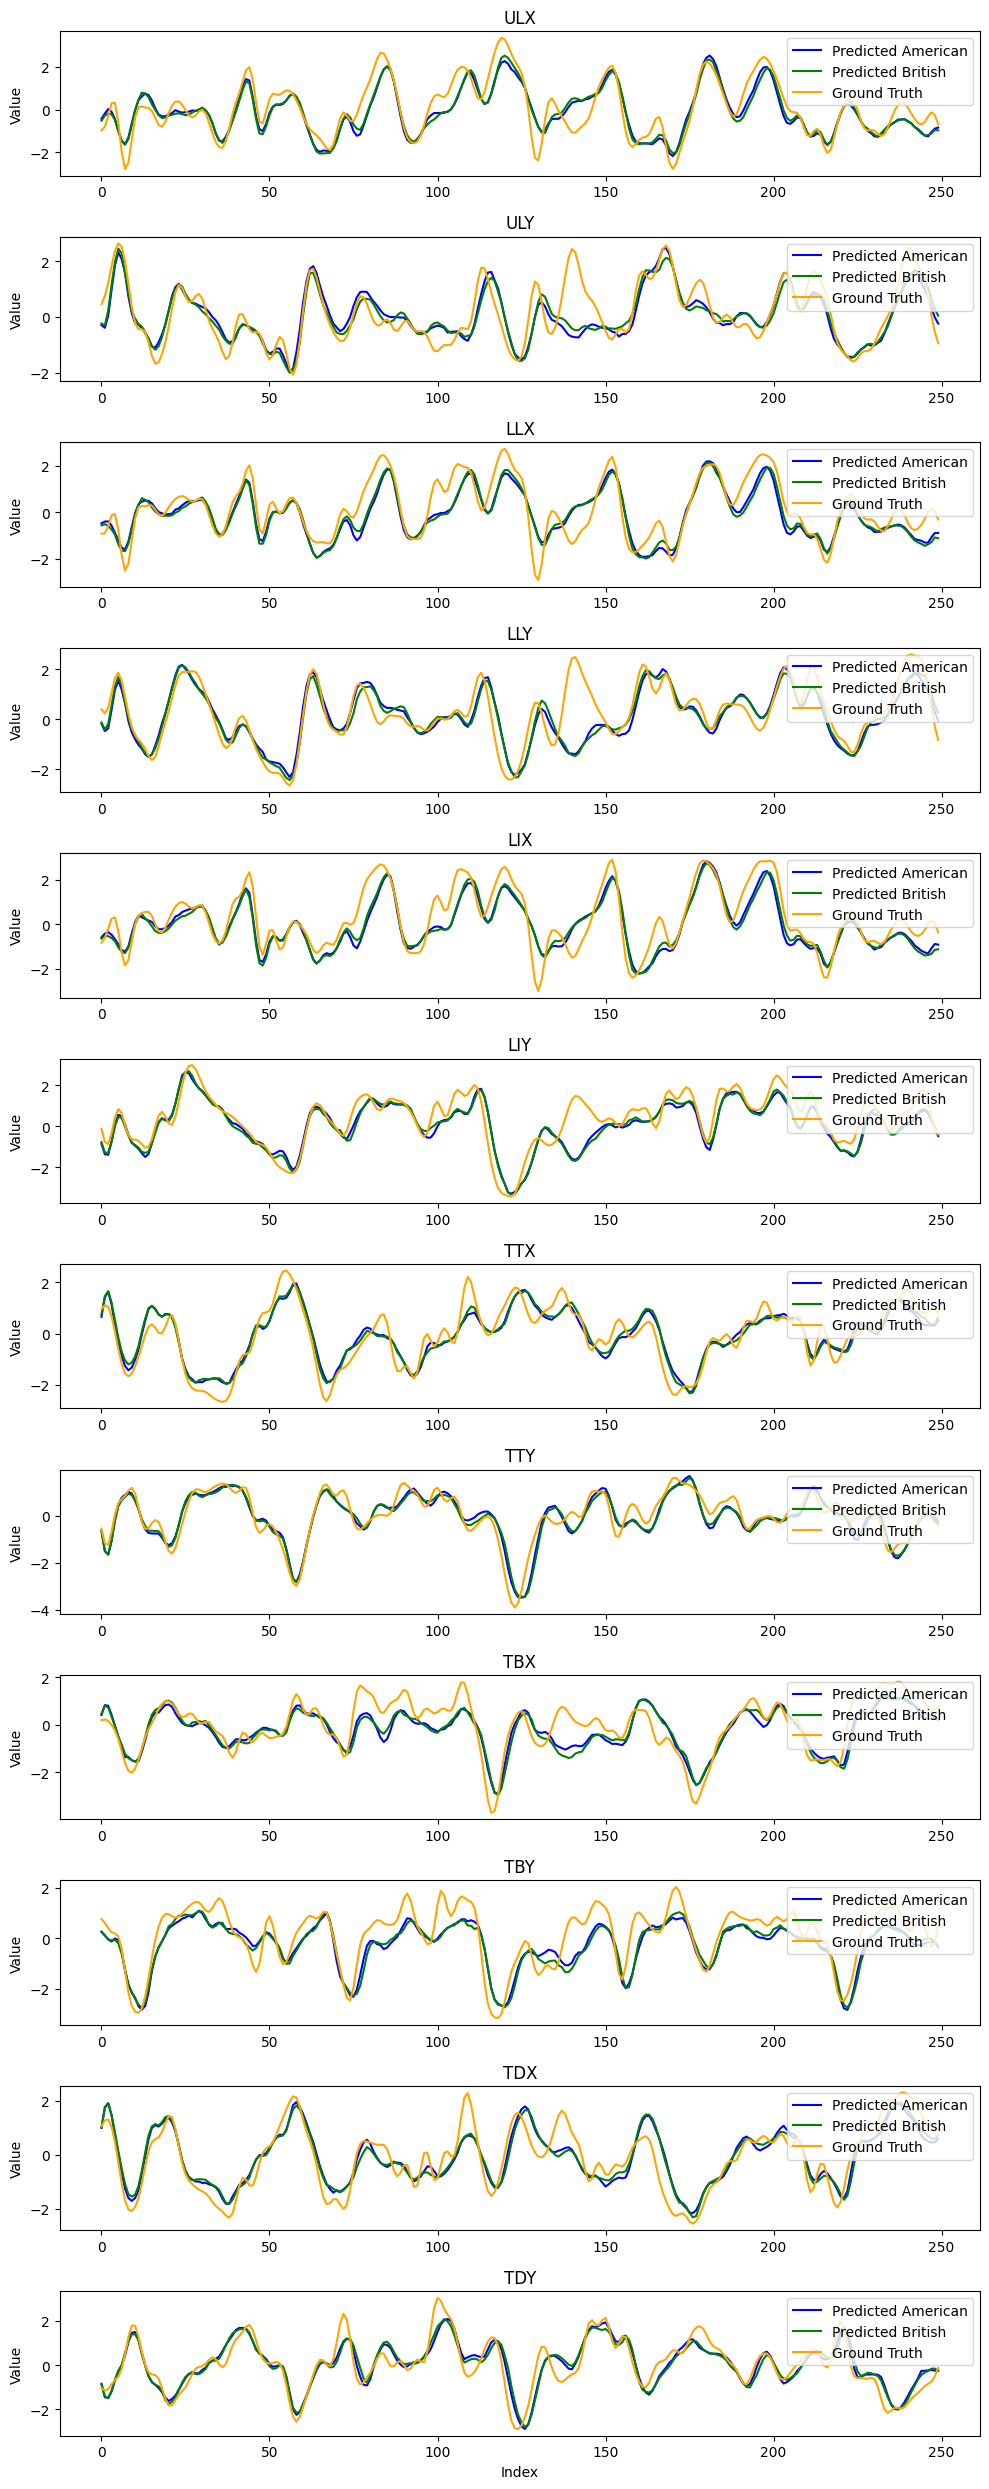

In [66]:
corr = plot_sparc(american_prediction, british_prediction, ground_truth)

In [67]:
corr

({'ULX': 0.8861243724822998,
  'ULY': 0.8230624198913574,
  'LLX': 0.8638700842857361,
  'LLY': 0.799615740776062,
  'LIX': 0.8830204010009766,
  'LIY': 0.8662502765655518,
  'TTX': 0.9218741059303284,
  'TTY': 0.9240289926528931,
  'TBX': 0.8655786514282227,
  'TBY': 0.8827376961708069,
  'TDX': 0.8952913880348206,
  'TDY': 0.9114795327186584},
 {'ULX': 0.8837802410125732,
  'ULY': 0.839754581451416,
  'LLX': 0.865006148815155,
  'LLY': 0.8008739352226257,
  'LIX': 0.8829043507575989,
  'LIY': 0.8671365976333618,
  'TTX': 0.9272209405899048,
  'TTY': 0.919826865196228,
  'TBX': 0.8399516344070435,
  'TBY': 0.8699041604995728,
  'TDX': 0.8928688764572144,
  'TDY': 0.8937763571739197})

In [68]:
{"American Correlations": sum(corr[0][k] for k in corr[0])/12,
 "British Correlations": sum(corr[1][k] for k in corr[1])/12}

{'American Correlations': 0.8769111384948095,
 'British Correlations': 0.8735837241013845}

In [61]:
american_prediction = british_output_american[0][0][:, :12].detach().cpu().numpy()
british_prediction = british_output_british[0][0][:, :12].detach().cpu().numpy()
ground_truth = british_data_sample[7][0][:, :12].detach().cpu().numpy()

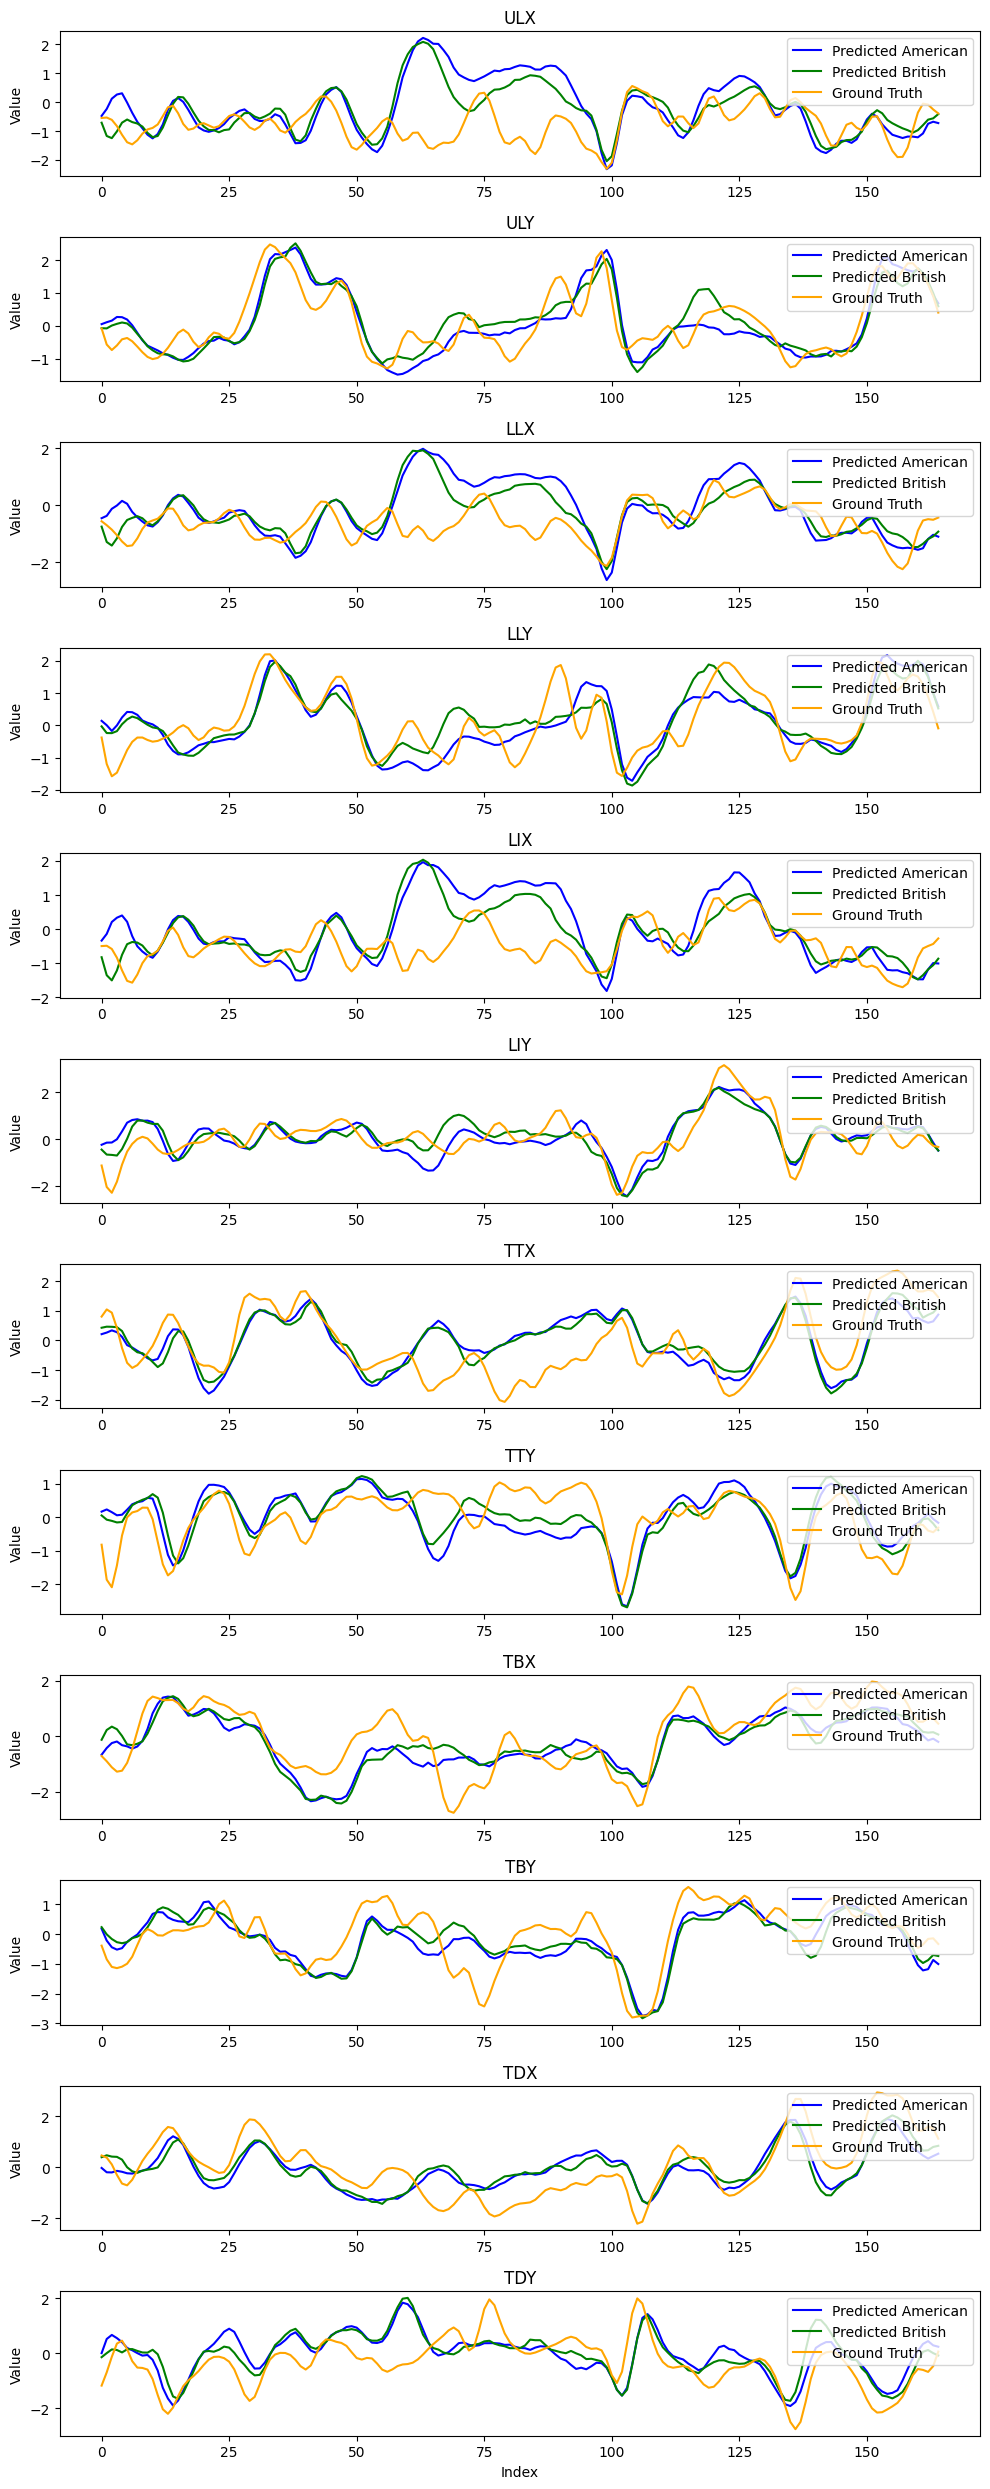

In [62]:
corr = plot_sparc(american_prediction, british_prediction, ground_truth)

In [63]:
corr

({'ULX': 0.10529952496290207,
  'ULY': 0.8438775539398193,
  'LLX': 0.42094942927360535,
  'LLY': 0.7461942434310913,
  'LIX': 0.4148431420326233,
  'LIY': 0.7304931282997131,
  'TTX': 0.6263142228126526,
  'TTY': 0.5246730446815491,
  'TBX': 0.8084675073623657,
  'TBY': 0.7406920790672302,
  'TDX': 0.7479966878890991,
  'TDY': 0.6059477925300598},
 {'ULX': 0.10784482210874557,
  'ULY': 0.819939911365509,
  'LLX': 0.3803107440471649,
  'LLY': 0.74864661693573,
  'LIX': 0.34590697288513184,
  'LIY': 0.7524288296699524,
  'TTX': 0.6556380987167358,
  'TTY': 0.6400396227836609,
  'TBX': 0.7588240504264832,
  'TBY': 0.6965935826301575,
  'TDX': 0.7443809509277344,
  'TDY': 0.6011331081390381})

In [64]:
{"American Correlations": sum(corr[0][k] for k in corr[0])/12,
 "British Correlations": sum(corr[1][k] for k in corr[1])/12}

{'American Correlations': 0.6096456963568926,
 'British Correlations': 0.6043072758863369}